### Example plots

In [1]:
import functions as fnc
import numpy as np
import sys
import verde as vd
from choclo.point import gravity_u as pointgrav
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
np.set_printoptions(threshold=sys.maxsize)
H0 = np.array([5, 5, 5])

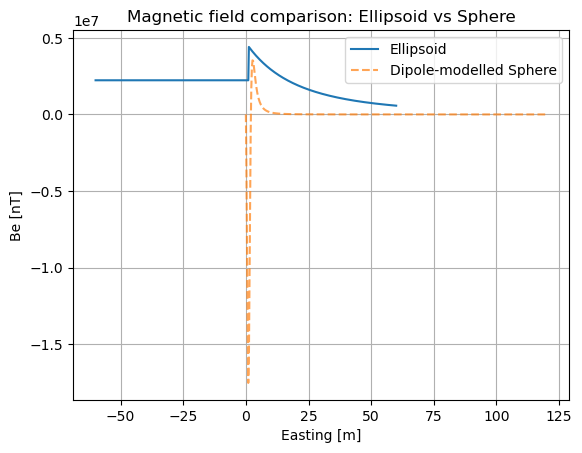

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import harmonica as hm
from functions import ProlateEllipsoid, ellipsoid_magnetics

mu_0 = 4 * np.pi * 1e-7
# Define external magnetic field
# ------------------------------
magnitude, inclination, declination = 55_000, 0.0, 90.0
igrf = np.array(hm.magnetic_angles_to_vec(magnitude, inclination, declination))  # shape (3,)

# Define ellipsoid (make it nearly a sphere)
# ------------------------------------------
a = 60.0
b = 59.999  # very close to a
ellipsoid = ProlateEllipsoid(a=a, b=b, yaw=0, pitch=0, centre=(1, 1, 1))
k = 0.1

# Define observation points along easting
# ---------------------------------------
easting = np.linspace(0, 2 * a, 501)
northing, upward = np.zeros_like(easting), np.zeros_like(easting)
coordinates = tuple(np.atleast_2d(c) for c in (easting, northing, upward))

# Compute magnetic field for ellipsoid
# ------------------------------------
be, bn, bu = ellipsoid_magnetics(coordinates, ellipsoid, k, igrf, field="b")
be = be.ravel()
be_anom = be  - mu_0 * igrf[0] * 1e9  

# Compute magnetic field for a sphere (analytic)
# ----------------------------------------------  

M = k * igrf # magnetisation due to a sphere... M = (3 * k / (3 + k)) * igrf ?
dipole = (1, 1, 1)
volume = (4/3) * np.pi * a**3  
magnetic_moment = volume * M
b_e, b_n, b_u = hm.dipole_magnetic(coordinates, dipole, magnetic_moment, field="b")
b_e = b_e.ravel() 

# Plot comparison
# ---------------
plt.plot(easting-60, be_anom, label="Ellipsoid")
plt.plot(easting, b_e * 1e-4, '--', label="Dipole-modelled Sphere", alpha=0.7)
plt.xlabel("Easting [m]")
plt.ylabel("Be [nT]")
plt.legend()
plt.title("Magnetic field comparison: Ellipsoid vs Sphere")
plt.grid(True)
plt.show()


In [ ]:
type(H0)


In [ ]:
# parameters used throughout plots

a, b, c = (7, 3, 2) # triaxial ellipsoid
yaw = 30
pitch = 60
roll = 0
n = [1, 2, 3]
triaxial_example = fnc.TriaxialEllipsoid(a, b, c, yaw, pitch, roll, (2, 2, 0))
triaxial_example2 = fnc.TriaxialEllipsoid(a, b, c, yaw, pitch, roll, (10, 10, 0))
density = 2000

# define observation points (2D grid) at surface height (z axis, 'Upward') = 5
coordinates = vd.grid_coordinates(region = (-20, 20, -20, 20), spacing = 0.5, extra_coords = 5)

### Colormaps of magnetic components

In [ ]:
be, bn, bu = fnc.ellipsoid_magnetics(coordinates, [triaxial_example], [((0.1, 0.1, 0.1), (0.2, 0.2, 0.2), (0.3, 0.3, 0.3))], H0)

In [ ]:
easting, northing = coordinates[:2]
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))

tmp = ax1.pcolormesh(easting, northing, be)
ax1.set_title("Easting component")
plt.colorbar(tmp, ax=ax1, label="be")

tmp = ax2.pcolormesh(easting, northing, bn)
ax2.set_title("Northing component")
plt.colorbar(tmp, ax=ax2, label="bn")

tmp = ax3.pcolormesh(easting, northing, bu)
ax3.set_title("Upward component")
plt.colorbar(tmp, ax=ax3, label="bu")

for ax in (ax1, ax2, ax3):
    ax.set_aspect("equal")

    
plt.tight_layout()
plt.show()

### Colourmaps of gravity components

In [ ]:
ge, gn, gu = fnc.ellipsoid_gravity(coordinates, triaxial_example, density=2000)

In [ ]:
easting, northing = coordinates[:2]
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))

tmp = ax1.pcolormesh(easting, northing, ge)
ax1.set_title("Easting component")
plt.colorbar(tmp, ax=ax1, label="ge")

tmp = ax2.pcolormesh(easting, northing, gn)
ax2.set_title("Northing component")
plt.colorbar(tmp, ax=ax2, label="gn")

tmp = ax3.pcolormesh(easting, northing, gu)
ax3.set_title("Upward component")
plt.colorbar(tmp, ax=ax3, label="gu")

for ax in (ax1, ax2, ax3):
    ax.set_aspect("equal")

    
plt.tight_layout()
plt.show()

### Interactive ellipsoid 

In [ ]:
%matplotlib notebook

V = fnc._get_V_as_Euler(yaw, pitch, roll) # Euler rotation matrix
x1, y1, z1 = fnc._generate_basic_ellipsoid(a, b, c) # creates ellipsoid surface
local_coords = fnc._global_to_local(x1, y1, z1, 0, V) # rotates ellipsoid surface


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

max_radius = max(a, b, c)
for axis in 'xyz':
    getattr(ax, 'set_{}lim'.format(axis))((-max_radius, max_radius))
    
ax.plot_surface(x1, y1, z1, color='green', alpha=0.6)
ax.plot_surface(local_coords[0], local_coords[1], local_coords[2], color='blue', alpha=0.6)

legend_elements = [
    Patch(facecolor='green', edgecolor='k', label='Original'),
    Patch(facecolor='blue', edgecolor='k', label='Rotated')
]
ax.legend(handles=legend_elements)

ax.set_xlabel('Northing')
ax.set_ylabel('Easting')
ax.set_zlabel('Upward')

### Colourmap of upward gravity component 

In [ ]:
e, n, u = coordinates

In [ ]:
_, _, gu = fnc.ellipsoid_gravity(coordinates, triaxial_example, density=density)

In [ ]:
plt.pcolormesh(e, n, gu)
plt.gca().set_aspect("equal")
plt.colorbar(label="gz")
plt.title(f"Vertical gravity at constant height {u[0][0]}")
plt.xlabel("Easting")
plt.ylabel("Northing")

plt.show()

### Decay comparison of ellipsoid body and point mass

In [ ]:
 # plot decay when moving along the z-axis
z = np.linspace(c, 10*c**2, 50)
x = y = np.zeros_like(z)

# lists to hold variables
gz = []
point_gz = []

# calculate ellipsoid mass
ellipsoid_mass =  density * 4/3 * np.pi * a * b * c

In [ ]:
_, _, gu = fnc.ellipsoid_gravity((x, y, z), triaxial_example, density=density)

In [ ]:
for i in range(len(x)):
        point_grav = pointgrav(x[i], y[i], z[i], 0, 0, 0, ellipsoid_mass)
        point_gz.append(point_grav)


In [ ]:
# plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

# plot 1: gravity decay of the two models
axs[0].set_title("Comparing ellipsoid gravity to point mass gravity at distance")
axs[0].plot(z, np.abs(gu), color='blue', label='Ellipsoid decay')
axs[0].plot(z, np.abs(point_gz), color='red', label='Point mass decay')
axs[0].set_ylabel('Gravity (m/s²)')
axs[0].set_xlabel('Distance from source (surface) (m)')
axs[0].legend()
axs[0].grid(alpha=0.3)

# plot 2: difference between the gravity models
axs[1].set_title("Difference between ellipsoid and point mass gravity")
axs[1].plot(z, np.abs(gu) - np.abs(point_gz), color='purple', label='Difference')
axs[1].set_xlabel('Distance from source (surface) (m)')
axs[1].set_ylabel('Change in gravity (m/s²)')
axs[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()